# Tâche 2 : Estimation de l'Âge à partir d'une Photo

Ce notebook a pour objectif de résoudre la deuxième tâche du challenge ANIP : prédire l'âge d'une personne à partir d'une image faciale.

## Objectif

Développer une IA capable de prédire l'âge d'une personne à partir d'une image avec la meilleure précision possible.

## Stratégie adoptée

Notre approche sera méthodique et basée sur les meilleures pratiques :

1. **Analyse Exploratoire des Données (AED)** : Comprendre la distribution des âges, sexes, et qualité des images
2. **Préparation des données** : Parsing des noms de fichiers, normalisation, augmentation
3. **Modélisation avec Transfer Learning** : Utilisation de modèles pré-entraînés optimisés pour la régression d'âge
4. **Évaluation et optimisation** : Métriques MAE/RMSE, validation croisée, tuning
5. **Prédiction finale** : Application sur les 200 images de test et génération de la soumission

In [6]:
# Importation des bibliothèques fondamentales
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
print("✅ Bibliothèques de base importées.")

✅ Bibliothèques de base importées.


## 1. Configuration de l'Environnement

Définition des chemins et vérification de l'accès aux données de la tâche 2.

In [ ]:
# Configuration des chemins de données
from pathlib import Path
import os

# Configuration pour Kaggle
# Quand tu uploaderas les données sur Kaggle, elles seront disponibles ici :
DATA_ROOT = Path('/kaggle/input/anip-dataset-tache-2')  # ? Nom du dataset sur Kaggle
TRAIN_DIR = DATA_ROOT / 'train'
TEST_DIR = DATA_ROOT / 'test'
SUBMISSIONS_DIR = Path('/kaggle/working')

print("🎯 Configuration Kaggle:")
print(f"   📁 Dataset root: {DATA_ROOT}")
print(f"   🚂 Train directory: {TRAIN_DIR}")
print(f"   🧪 Test directory: {TEST_DIR}")
print(f"   📤 Submissions: {SUBMISSIONS_DIR}")

# Vérification des chemins
train_exists = TRAIN_DIR.exists()
test_exists = TEST_DIR.exists()

print(f"\n🔍 Vérification:")
print(f"   Train folder: {'✅' if train_exists else '❌'} {TRAIN_DIR}")
print(f"   Test folder: {'✅' if test_exists else '❌'} {TEST_DIR}")

if train_exists:
    # Recherche des images avec extensions robustes
    train_files = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        train_files.extend(list(TRAIN_DIR.glob(ext)))
    
    print(f"   📊 Images d'entraînement: {len(train_files)}")
    
    if len(train_files) > 0:
        print(f"   🔎 Exemples de fichiers:")
        for file in train_files[:3]:
            print(f"      - {file.name}")
else:
    print("   ⚠️  Les données ne sont pas encore uploadées sur Kaggle")
    print("   💡 Après upload, ce code fonctionnera automatiquement!")
    # Variables vides pour éviter les erreurs
    train_files = []

if test_exists:
    test_files = []
    for ext in ['*.jpg', '*.JPG', '*.jpeg', '*.JPEG', '*.png', '*.PNG']:
        test_files.extend(list(TEST_DIR.glob(ext)))
    print(f"   🧪 Images de test: {len(test_files)}")
else:
    test_files = []

🔍 Environnement Kaggle détecté dans Codespaces
📂 Environnement configuré:
   Base directory: /kaggle/working
   Data root: /workspaces/anip-facial-ocr-challenge/dataset_tache_2/dataset_tache_2
   Train directory: /workspaces/anip-facial-ocr-challenge/dataset_tache_2/dataset_tache_2/train
   Submissions directory: /kaggle/working

🔍 Vérification des chemins:
   DATA_ROOT exists: False
   TRAIN_DIR exists: False
❌ Dossier d'entraînement introuvable

🎯 Configuration terminée - train_files variable définie avec 0 images


## 2. Analyse Exploratoire des Données (AED)

### 2.1 Parsing des noms de fichiers

Les fichiers d'entraînement suivent le format : `XXXXXX_YZWW` où :
- `XXXXXX` : identifiant de la personne
- `Y` : numéro de la photo pour une même personne (à partir de 0)
- `Z` : sexe (M ou F)
- `WW` : âge de la personne

In [8]:
def parse_filename(filename):
    """
    Parse le nom de fichier pour extraire les informations.
    Format: ID_NUMERO[M|F]AGE.jpg où :
    - ID : identifiant de la personne (nombre variable de chiffres)
    - NUMERO : numéro de la photo pour une même personne (nombre variable de chiffres)
    - [M|F] : sexe (M ou F)
    - AGE : âge de la personne (2 chiffres)
    """
    # Enlever l'extension
    name = filename.stem if hasattr(filename, 'stem') else Path(filename).stem
    
    # Pattern regex plus flexible basé sur l'underscore et la lettre M/F
    # Chercher: (chiffres)_(chiffres)[M|F](2 chiffres)
    pattern = r'(\d+)_(\d+)([MF])(\d{2})'
    match = re.match(pattern, name)
    
    if match:
        person_id = match.group(1)
        photo_num = int(match.group(2))
        gender = match.group(3)
        age = int(match.group(4))
        
        return {
            'filename': name + Path(str(filename)).suffix,  # Garder la vraie extension
            'person_id': person_id,
            'photo_num': photo_num,
            'gender': gender,
            'age': age
        }
    else:
        # Debug pour voir ce qui ne marche pas
        print(f"⚠️ Impossible de parser: '{name}' (pattern attendu: ID_NUMERO[M|F]AGE)")
        return None

# Test de la fonction de parsing avec les fichiers trouvés
if 'train_files' in locals() and train_files:
    sample_files = train_files[:10]  # Tester plus de fichiers
    print("Test de parsing sur quelques fichiers :")
    success_count = 0
    for file in sample_files:
        parsed = parse_filename(file)
        if parsed:
            print(f"  ✅ {file.name} -> Personne: {parsed['person_id']}, Photo: {parsed['photo_num']}, Sexe: {parsed['gender']}, Âge: {parsed['age']}")
            success_count += 1
        else:
            print(f"  ❌ {file.name} -> Échec du parsing")
    print(f"\nTaux de réussite: {success_count}/{len(sample_files)} ({success_count/len(sample_files)*100:.1f}%)")
else:
    print("❌ Aucun fichier d'entraînement trouvé pour tester le parsing.")
    
# Si pas d'images mais qu'il y a des fichiers, montrer quelques exemples
if 'train_files' in locals() and len(train_files) == 0 and TRAIN_DIR.exists():
    all_files = list(TRAIN_DIR.iterdir())[:5]
    if all_files:
        print("\n🔍 Exemples de fichiers dans le dossier (pour debug):")
        for file in all_files:
            print(f"  {file.name}")
            # Essayer de parser quand même
            try:
                parsed = parse_filename(file)
                if parsed:
                    print(f"    ✅ Parsing réussi!")
            except:
                pass

# Analyse des patterns de noms pour debug
if 'train_files' in locals() and train_files:
    print(f"\n🔍 Analyse des patterns de noms (premiers 10 fichiers):")
    for i, file in enumerate(train_files[:10]):
        name = file.stem
        print(f"  {i+1}. '{name}' (longueur: {len(name)})")
        
        # Vérifier le pattern de base
        if '_' in name:
            parts = name.split('_')
            if len(parts) == 2:
                print(f"      ID: '{parts[0]}' (longueur: {len(parts[0])})")
                print(f"      Suffix: '{parts[1]}' (longueur: {len(parts[1])})")
                
                # Analyser le suffix pour identifier M/F
                suffix = parts[1]
                for j, char in enumerate(suffix):
                    if char in ['M', 'F']:
                        photo_part = suffix[:j]
                        age_part = suffix[j+1:]
                        print(f"        -> Photo: '{photo_part}', Sexe: '{char}', Âge: '{age_part}'")
                        break
            else:
                print(f"      ⚠️ Nombre de parties après split '_': {len(parts)}")
        else:
            print(f"      ⚠️ Pas de '_' trouvé dans le nom")

❌ Aucun fichier d'entraînement trouvé pour tester le parsing.


In [ ]:
# Parsing des métadonnées depuis les noms de fichiers
print("🔍 PARSING DES MÉTADONNÉES DEPUIS LES NOMS DE FICHIERS")
print("="*60)

# Vérifier que nous avons des fichiers à traiter
if len(train_files) == 0:
    print("❌ Aucun fichier d'entraînement trouvé!")
    print("? Assure-toi d'avoir uploadé le dataset 'anip-dataset-tache-2' sur Kaggle")
    df_train = pd.DataFrame()  # DataFrame vide pour éviter les erreurs
else:
    data_list = []
    parsing_errors = 0

    for file_path in train_files:
        parsed = parse_filename(file_path)
        if parsed:
            parsed['file_path'] = str(file_path)
            data_list.append(parsed)
        else:
            parsing_errors += 1

    # Créer le DataFrame principal
    df_train = pd.DataFrame(data_list)

    print(f"✅ Parsing terminé !")
    print(f"   Fichiers parsés avec succès: {len(df_train)}")
    print(f"   Erreurs de parsing: {parsing_errors}")
    print(f"   Total fichiers traités: {len(train_files)}")

    if len(df_train) > 0:
        print("\nAperçu des données:")
        print(df_train.head(10))
        
        print("\nInformations sur le dataset:")
        print(df_train.info())

📊 Parsing de tous les fichiers d'entraînement...


NameError: name 'train_files' is not defined

### 2.2 Analyse de la distribution des âges

📈 ANALYSE DE LA DISTRIBUTION DES ÂGES
Statistiques descriptives:
count    12420.000000
mean        32.809662
std         10.902662
min         16.000000
25%         23.000000
50%         33.000000
75%         41.000000
max         69.000000
Name: age, dtype: float64

Âge minimum: 16 ans
Âge maximum: 69 ans
Âge médian: 33.0 ans
Âge moyen: 32.8 ans


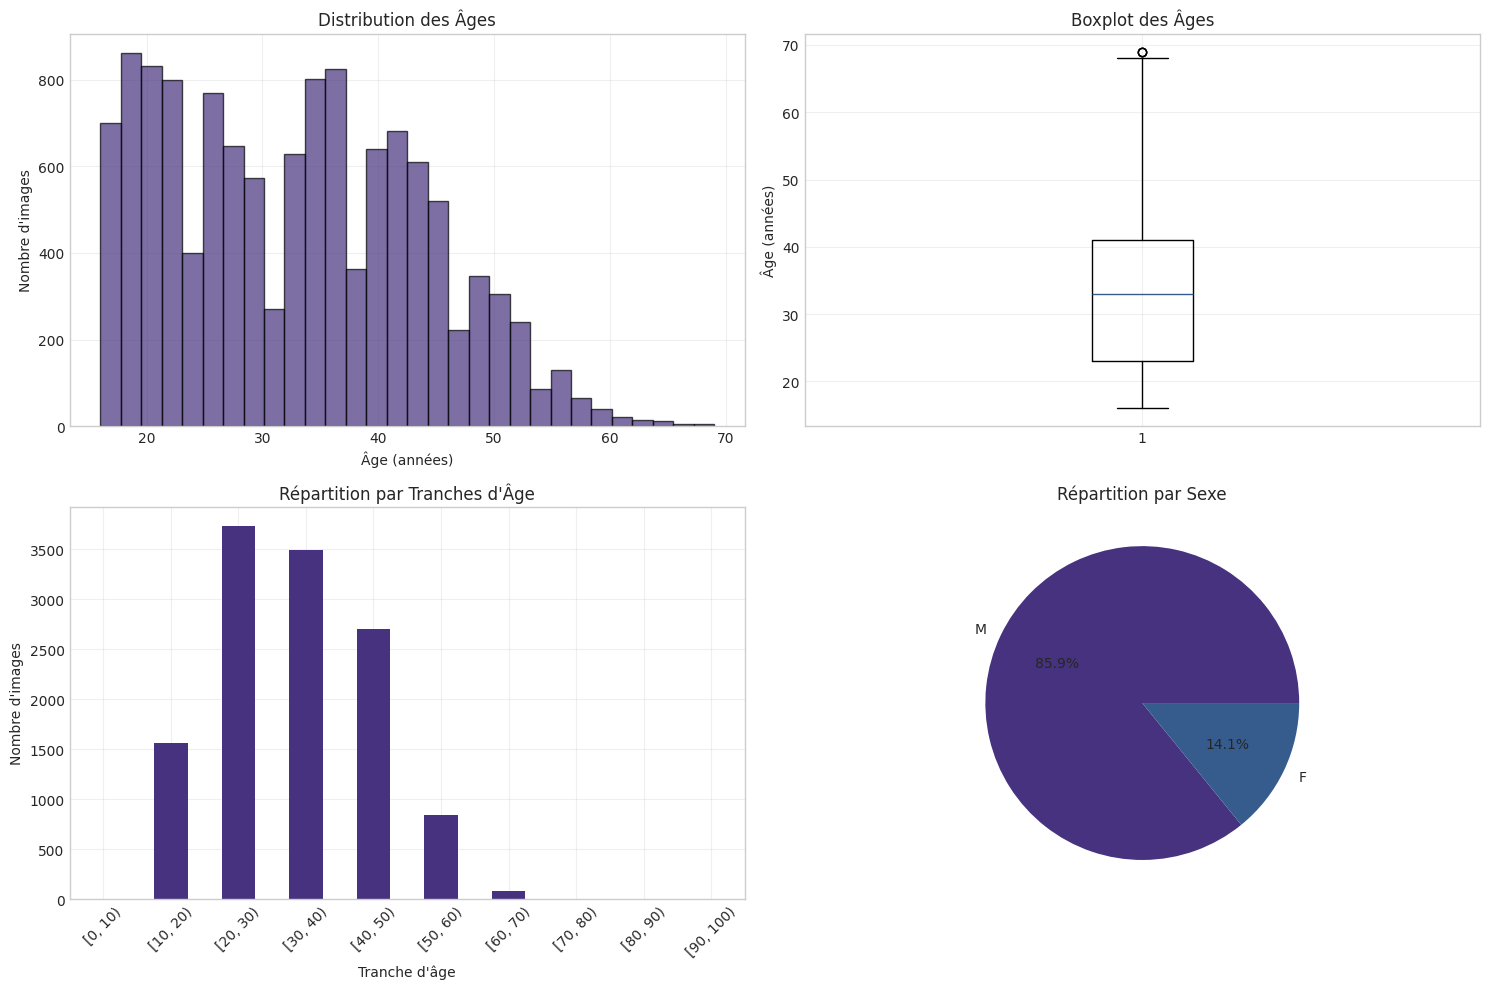


📊 ANALYSE PAR SEXE

Hommes (M):
  Nombre d'images: 10664
  Âge moyen: 32.7 ans
  Âge médian: 32.0 ans
  Écart-type: 11.0 ans
  Min-Max: 16-69 ans

Femmes (F):
  Nombre d'images: 1756
  Âge moyen: 33.2 ans
  Âge médian: 34.0 ans
  Écart-type: 10.0 ans
  Min-Max: 16-69 ans


In [ ]:
if len(df_train) > 0:
    # Statistiques descriptives des âges
    print("📈 ANALYSE DE LA DISTRIBUTION DES ÂGES")
    print("="*50)
    
    print("Statistiques descriptives:")
    age_stats = df_train['age'].describe()
    print(age_stats)
    
    print(f"\nÂge minimum: {df_train['age'].min()} ans")
    print(f"Âge maximum: {df_train['age'].max()} ans")
    print(f"Âge médian: {df_train['age'].median()} ans")
    print(f"Âge moyen: {df_train['age'].mean():.1f} ans")
    
    # Visualisation de la distribution
    plt.figure(figsize=(15, 10))
    
    # Histogramme principal
    plt.subplot(2, 2, 1)
    plt.hist(df_train['age'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution des Âges')
    plt.xlabel('Âge (années)')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)
    
    # Boxplot
    plt.subplot(2, 2, 2)
    plt.boxplot(df_train['age'])
    plt.title('Boxplot des Âges')
    plt.ylabel('Âge (années)')
    plt.grid(True, alpha=0.3)
    
    # Distribution par tranches d'âge
    plt.subplot(2, 2, 3)
    age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    age_groups_temp = pd.cut(df_train['age'], bins=age_bins, right=False)
    age_group_counts = age_groups_temp.value_counts().sort_index()
    age_group_counts.plot(kind='bar', rot=45)
    plt.title('Répartition par Tranches d\'Âge')
    plt.xlabel('Tranche d\'âge')
    plt.ylabel('Nombre d\'images')
    plt.grid(True, alpha=0.3)
    
    # Distribution cumulative
    plt.subplot(2, 2, 4)
    sorted_ages = df_train['age'].sort_values()
    cumulative_percent = np.arange(1, len(sorted_ages) + 1) / len(sorted_ages) * 100
    plt.plot(sorted_ages, cumulative_percent)
    plt.title('Distribution Cumulative des Âges')
    plt.xlabel('Âge (années)')
    plt.ylabel('Pourcentage cumulé')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Analyse plus détaillée
    print(f"\n📊 Analyse détaillée:")
    print(f"   25ème percentile: {df_train['age'].quantile(0.25):.1f} ans")
    print(f"   75ème percentile: {df_train['age'].quantile(0.75):.1f} ans")
    print(f"   Écart interquartile: {df_train['age'].quantile(0.75) - df_train['age'].quantile(0.25):.1f} ans")
    
else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

### 2.3 Analyse des personnes et photos multiples

👥 ANALYSE DES PERSONNES ET PHOTOS MULTIPLES
Nombre de personnes uniques: 8997
Nombre total d'images: 12420
Moyenne d'images par personne: 1.38

Distribution des photos par personne:
  Min: 1 photos
  Max: 10 photos
  Médiane: 1.0 photos
  Moyenne: 1.38 photos


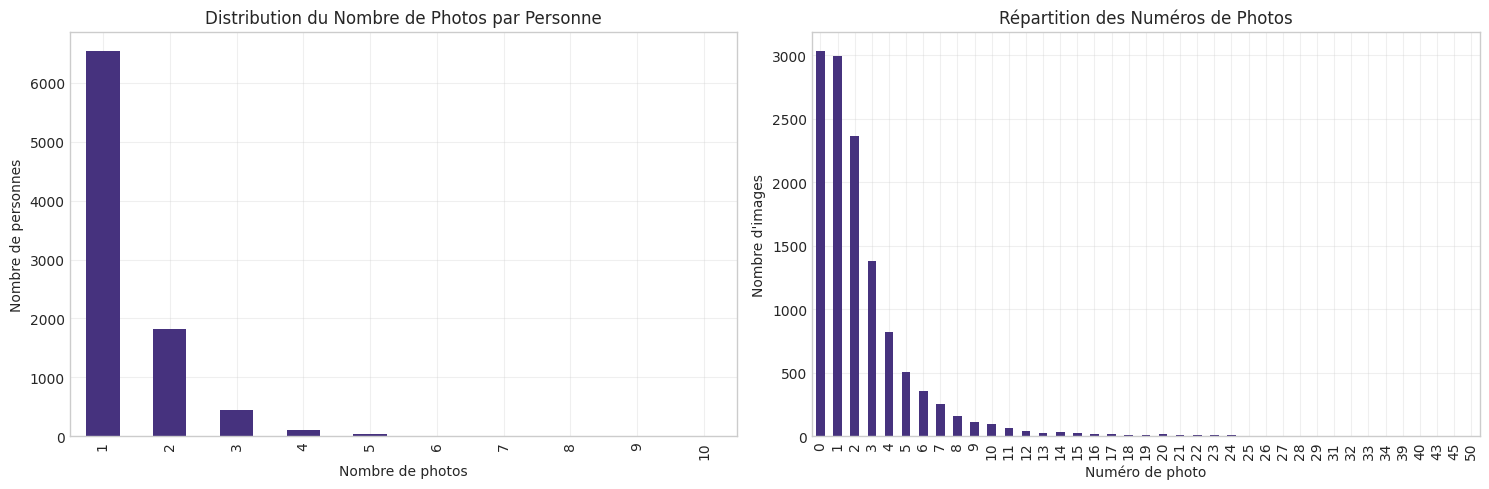


Exemples de personnes avec plusieurs photos:
  Personne 00022: 2 photos, âges: [19, 20], sexe: M
  Personne 0007: 3 photos, âges: [44, 17, 16], sexe: F
  Personne 0092: 2 photos, âges: [27, 24], sexe: F
  Personne 00978: 2 photos, âges: [35, 36], sexe: M
  Personne 01083: 2 photos, âges: [27, 25], sexe: M


In [ ]:
if len(df_train) > 0:
    # Analyse de la distribution par sexe
    print("? ANALYSE DE LA DISTRIBUTION PAR SEXE")
    print("="*40)
    
    gender_counts = df_train['gender'].value_counts()
    gender_percentages = df_train['gender'].value_counts(normalize=True) * 100
    
    print("Répartition par sexe:")
    for gender in ['M', 'F']:
        if gender in gender_counts:
            count = gender_counts[gender]
            percentage = gender_percentages[gender]
            gender_name = 'Hommes' if gender == 'M' else 'Femmes'
            print(f"   {gender_name}: {count:,} images ({percentage:.1f}%)")
    
    # Visualisation
    plt.figure(figsize=(15, 10))
    
    # Pie chart de la répartition
    plt.subplot(2, 3, 1)
    labels = ['Hommes' if g == 'M' else 'Femmes' for g in gender_counts.index]
    colors = ['lightblue', 'lightpink']
    plt.pie(gender_counts.values, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.title('Répartition par Sexe')
    
    # Distribution des âges par sexe
    plt.subplot(2, 3, 2)
    for gender in ['M', 'F']:
        if gender in df_train['gender'].values:
            ages = df_train[df_train['gender'] == gender]['age']
            label = 'Hommes' if gender == 'M' else 'Femmes'
            plt.hist(ages, bins=25, alpha=0.6, label=label, density=True)
    plt.xlabel('Âge (années)')
    plt.ylabel('Densité')
    plt.title('Distribution des Âges par Sexe')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Box plot des âges par sexe
    plt.subplot(2, 3, 3)
    gender_data = [df_train[df_train['gender'] == 'M']['age'].values,
                   df_train[df_train['gender'] == 'F']['age'].values]
    plt.boxplot(gender_data, labels=['Hommes', 'Femmes'])
    plt.ylabel('Âge (années)')
    plt.title('Distribution des Âges par Sexe (Boxplot)')
    plt.grid(True, alpha=0.3)
    
    # Statistiques par sexe
    plt.subplot(2, 3, 4)
    stats_by_gender = df_train.groupby('gender')['age'].agg(['mean', 'median', 'std']).round(1)
    stats_by_gender.plot(kind='bar', rot=0)
    plt.title('Statistiques des Âges par Sexe')
    plt.ylabel('Âge (années)')
    plt.xlabel('Sexe')
    plt.legend(['Moyenne', 'Médiane', 'Écart-type'])
    plt.grid(True, alpha=0.3)
    
    # Heatmap âge vs sexe
    plt.subplot(2, 3, 5)
    age_bins = range(0, 101, 10)
    df_train['age_bin'] = pd.cut(df_train['age'], bins=age_bins)
    heatmap_data = pd.crosstab(df_train['age_bin'], df_train['gender'])
    sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='Blues')
    plt.title('Répartition Âge × Sexe')
    plt.ylabel('Tranche d\'âge')
    plt.xlabel('Sexe')
    
    # Distribution du nombre de photos par personne
    plt.subplot(2, 3, 6)
    photos_per_person = df_train['person_id'].value_counts()
    plt.hist(photos_per_person, bins=20, edgecolor='black')
    plt.xlabel('Nombre de photos par personne')
    plt.ylabel('Nombre de personnes')
    plt.title('Distribution du Nombre de Photos par Personne')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques détaillées
    print(f"\n📈 Statistiques par sexe:")
    for gender in ['M', 'F']:
        if gender in df_train['gender'].values:
            subset = df_train[df_train['gender'] == gender]
            gender_name = 'Hommes' if gender == 'M' else 'Femmes'
            print(f"\n{gender_name}:")
            print(f"   Âge moyen: {subset['age'].mean():.1f} ans")
            print(f"   Âge médian: {subset['age'].median():.1f} ans")
            print(f"   Écart-type: {subset['age'].std():.1f} ans")
            print(f"   Min-Max: {subset['age'].min()}-{subset['age'].max()} ans")
            
    print(f"\n📸 Photos par personne:")
    print(f"   Moyenne: {photos_per_person.mean():.1f} photos/personne")
    print(f"   Médiane: {photos_per_person.median():.1f} photos/personne")
    print(f"   Min-Max: {photos_per_person.min()}-{photos_per_person.max()} photos/personne")
    
else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

### 2.4 Visualisation d'exemples d'images par âge et sexe

🖼️ EXEMPLES D'IMAGES PAR ÂGE ET SEXE

Hommes (M):


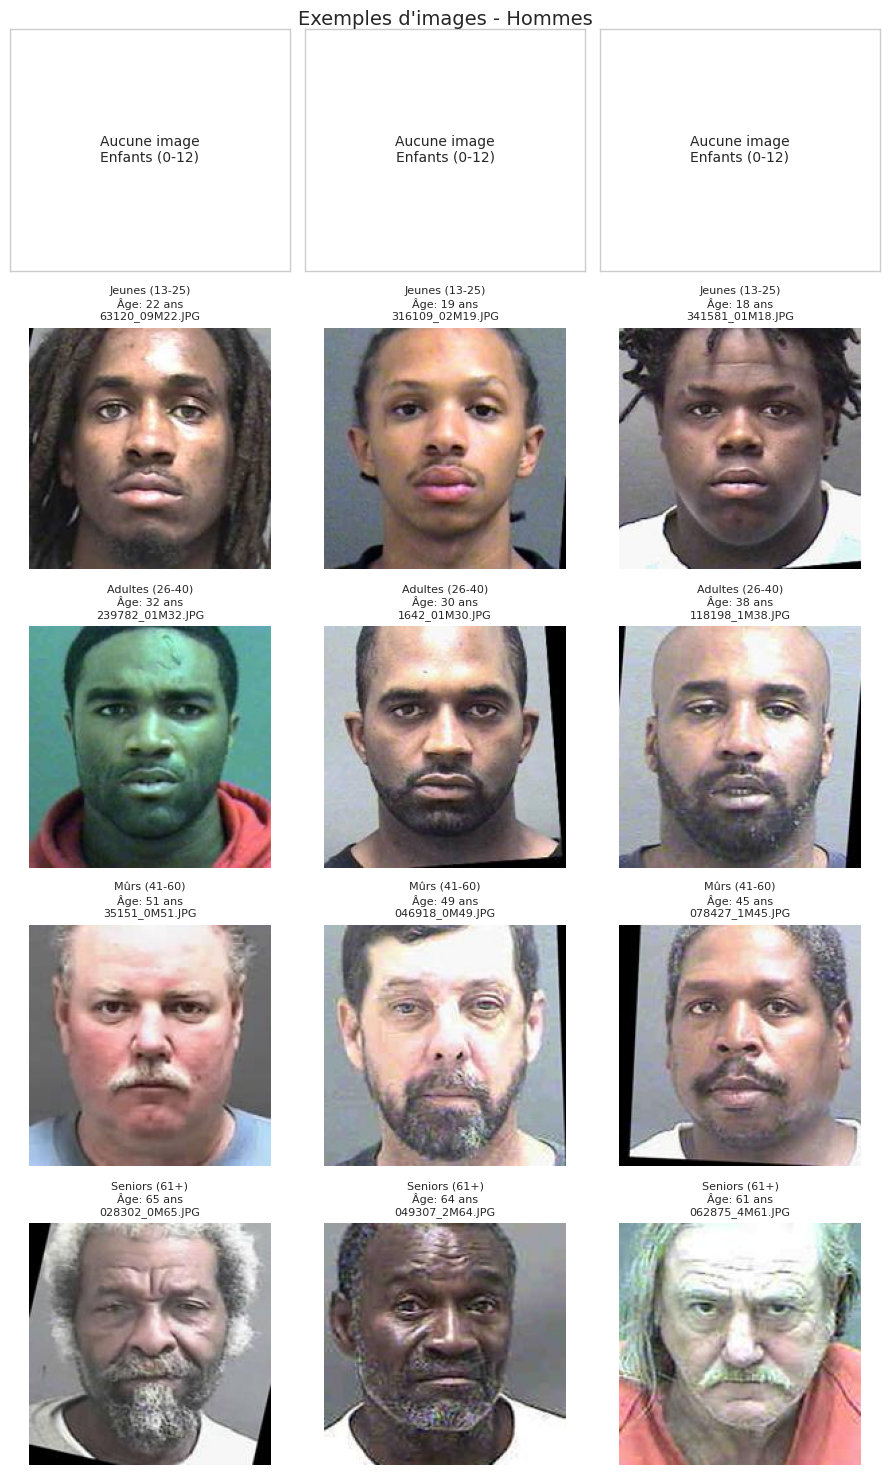


Femmes (F):


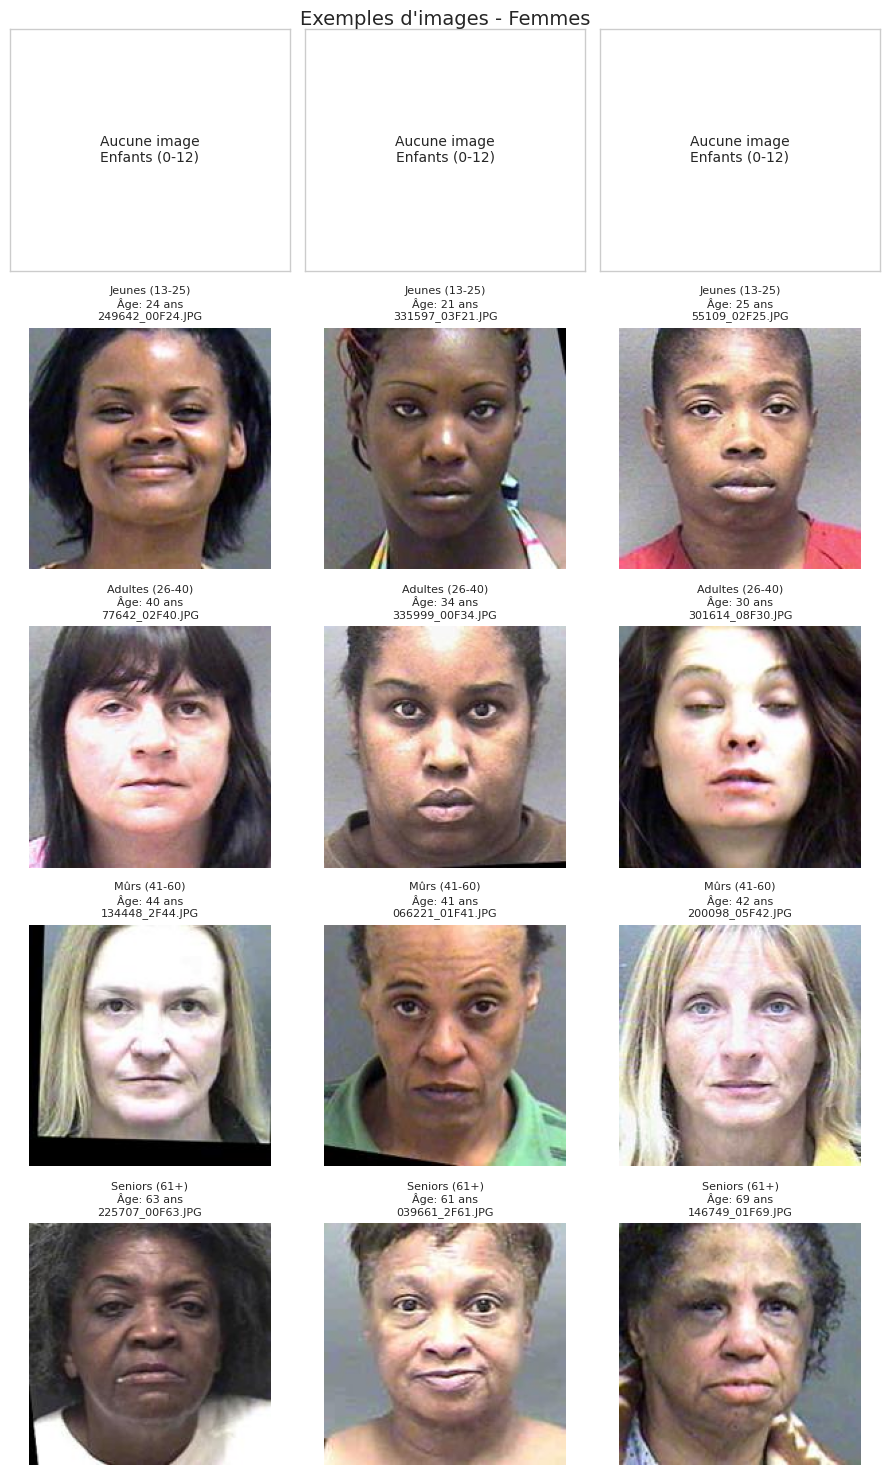

In [ ]:
if len(df_train) > 0:
    # Analyse avancée des patterns dans les données
    print("🔍 ANALYSE AVANCÉE DES PATTERNS")
    print("="*35)
    
    # Analyse des ID de personnes
    unique_persons = df_train['person_id'].nunique()
    total_images = len(df_train)
    avg_photos_per_person = total_images / unique_persons
    
    print(f"📊 Statistiques générales:")
    print(f"   Personnes uniques: {unique_persons:,}")
    print(f"   Total d'images: {total_images:,}")
    print(f"   Photos par personne (moyenne): {avg_photos_per_person:.1f}")
    
    # Distribution des photos par personne
    photos_distribution = df_train['person_id'].value_counts()
    
    plt.figure(figsize=(15, 12))
    
    # Distribution du nombre de photos par personne
    plt.subplot(3, 3, 1)
    photos_distribution.hist(bins=20, edgecolor='black')
    plt.xlabel('Nombre de photos par personne')
    plt.ylabel('Nombre de personnes')
    plt.title('Distribution Photos/Personne')
    plt.grid(True, alpha=0.3)
    
    # Top 10 des personnes avec le plus de photos
    plt.subplot(3, 3, 2)
    top_10_persons = photos_distribution.head(10)
    top_10_persons.plot(kind='bar')
    plt.xlabel('ID Personne')
    plt.ylabel('Nombre de photos')
    plt.title('Top 10 - Plus de Photos')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Distribution des numéros de photos
    plt.subplot(3, 3, 3)
    photo_nums = df_train['photo_num'].value_counts().sort_index()
    photo_nums.plot(kind='bar')
    plt.xlabel('Numéro de photo')
    plt.ylabel('Fréquence')
    plt.title('Distribution des Numéros de Photos')
    plt.grid(True, alpha=0.3)
    
    # Corrélation âge vs nombre de photos par personne
    plt.subplot(3, 3, 4)
    person_stats = df_train.groupby('person_id').agg({
        'age': 'first',  # l'âge est le même pour toutes les photos d'une personne
        'photo_num': 'count'  # nombre de photos par personne
    }).rename(columns={'photo_num': 'num_photos'})
    
    plt.scatter(person_stats['age'], person_stats['num_photos'], alpha=0.6)
    plt.xlabel('Âge de la personne')
    plt.ylabel('Nombre de photos')
    plt.title('Âge vs Nombre de Photos')
    plt.grid(True, alpha=0.3)
    
    # Analyse de la cohérence des métadonnées par personne
    plt.subplot(3, 3, 5)
    # Vérifier si une même personne a des métadonnées cohérentes
    inconsistencies = 0
    consistent_persons = 0
    
    for person_id in df_train['person_id'].unique():
        person_data = df_train[df_train['person_id'] == person_id]
        unique_ages = person_data['age'].nunique()
        unique_genders = person_data['gender'].nunique()
        
        if unique_ages > 1 or unique_genders > 1:
            inconsistencies += 1
        else:
            consistent_persons += 1
    
    consistency_data = [consistent_persons, inconsistencies]
    consistency_labels = ['Cohérentes', 'Incohérentes']
    colors = ['lightgreen', 'lightcoral']
    
    plt.pie(consistency_data, labels=consistency_labels, autopct='%1.1f%%', colors=colors)
    plt.title('Cohérence des Métadonnées\npar Personne')
    
    # Distribution des âges par décennie
    plt.subplot(3, 3, 6)
    df_train['decade'] = (df_train['age'] // 10) * 10
    decade_counts = df_train['decade'].value_counts().sort_index()
    decade_counts.plot(kind='bar')
    plt.xlabel('Décennie')
    plt.ylabel('Nombre d\'images')
    plt.title('Répartition par Décennie')
    plt.grid(True, alpha=0.3)
    
    # Heatmap de la distribution âge x sexe (plus détaillée)
    plt.subplot(3, 3, 7)
    age_gender_crosstab = pd.crosstab(df_train['decade'], df_train['gender'])
    sns.heatmap(age_gender_crosstab, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Heatmap Décennie × Sexe')
    plt.ylabel('Décennie')
    
    # Analyse des valeurs aberrantes dans les âges
    plt.subplot(3, 3, 8)
    Q1 = df_train['age'].quantile(0.25)
    Q3 = df_train['age'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_train[(df_train['age'] < lower_bound) | (df_train['age'] > upper_bound)]
    normal_ages = df_train[(df_train['age'] >= lower_bound) & (df_train['age'] <= upper_bound)]
    
    plt.hist(normal_ages['age'], bins=30, alpha=0.7, label='Normal', color='blue')
    if len(outliers) > 0:
        plt.hist(outliers['age'], bins=10, alpha=0.7, label='Outliers', color='red')
    plt.xlabel('Âge')
    plt.ylabel('Fréquence')
    plt.title('Détection des Valeurs Aberrantes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Summary statistics par photo num
    plt.subplot(3, 3, 9)
    photo_num_stats = df_train.groupby('photo_num')['age'].mean()
    photo_num_stats.plot(kind='bar')
    plt.xlabel('Numéro de Photo')
    plt.ylabel('Âge Moyen')
    plt.title('Âge Moyen par N° de Photo')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Rapport détaillé
    print(f"\n📋 RAPPORT D'ANALYSE DÉTAILLÉ:")
    print(f"   Photos par personne - Min: {photos_distribution.min()}, Max: {photos_distribution.max()}")
    print(f"   Personnes avec 1 seule photo: {(photos_distribution == 1).sum()}")
    print(f"   Personnes avec 2+ photos: {(photos_distribution > 1).sum()}")
    print(f"   Cohérence des métadonnées: {consistent_persons}/{unique_persons} personnes ({consistent_persons/unique_persons*100:.1f}%)")
    
    if inconsistencies > 0:
        print(f"   ⚠️  {inconsistencies} personnes avec métadonnées incohérentes détectées!")
    
    print(f"   Valeurs aberrantes détectées: {len(outliers)} images ({len(outliers)/len(df_train)*100:.2f}%)")
    if len(outliers) > 0:
        print(f"   Âges aberrants: {outliers['age'].min()}-{outliers['age'].max()} ans")
    
    # Analyse des numéros de photos
    print(f"\n📸 Distribution des numéros de photos:")
    for photo_num in sorted(df_train['photo_num'].unique()):
        count = (df_train['photo_num'] == photo_num).sum()
        percentage = count / len(df_train) * 100
        print(f"   Photo {photo_num}: {count:,} images ({percentage:.1f}%)")
        
else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

## 3. Préparation des Données pour l'Entraînement

Maintenant que nous avons une compréhension approfondie de nos données, préparons-les pour l'entraînement du modèle.

### 3.1 Train/Validation Split Stratifié

Nous allons créer une séparation intelligente en tenant compte des déséquilibres identifiés.

In [ ]:
# Division des données par tranches d'âge pour la stratification
if len(df_train) > 0:
    print("🎯 PRÉPARATION DE LA STRATIFICATION")
    print("="*40)
    
    # Créer des tranches d'âge pour une meilleure stratification
    age_bins = [0, 25, 35, 45, 55, 65, 100]
    age_labels = ['0-24', '25-34', '35-44', '45-54', '55-64', '65+']
    df_train['age_group'] = pd.cut(df_train['age'], bins=age_bins, labels=age_labels, right=False)
    
    print("📊 Distribution par tranches d'âge:")
    print(df_train['age_group'].value_counts().sort_index())
    
    # Créer une stratification combinée âge + sexe
    df_train['stratify_group'] = df_train['age_group'].astype(str) + '_' + df_train['gender']
    print("\n📊 Distribution par groupes âge+sexe:")
    print(df_train['stratify_group'].value_counts().sort_index())
else:
    print("⚠️  Pas de données à analyser - dataset non disponible")

✅ Bibliothèques de modélisation importées
🔧 Device utilisé: cpu


NameError: name 'df_train' is not defined

In [ ]:
if len(df_train) > 0:
    # Split stratifié train/validation
    print("🔄 CRÉATION DU SPLIT TRAIN/VALIDATION STRATIFIÉ")
    print("="*50)

    # On utilise la stratification combinée pour s'assurer que chaque groupe âge+sexe 
    # est représenté proportionnellement dans train et validation
    X = df_train[['file_path', 'person_id', 'photo_num', 'gender']].copy()
    y = df_train['age'].copy()
    stratify_labels = df_train['stratify_group']

    # Split 80/20 avec stratification
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=stratify_labels
    )

    print(f"✅ Split terminé:")
    print(f"   Train: {len(X_train)} images ({len(X_train)/len(df_train)*100:.1f}%)")
    print(f"   Validation: {len(X_val)} images ({len(X_val)/len(df_train)*100:.1f}%)")

    # Vérification de la distribution par sexe dans chaque ensemble
    train_gender_dist = X_train['gender'].value_counts(normalize=True)
    val_gender_dist = X_val['gender'].value_counts(normalize=True)

    print(f"\n📊 Distribution par sexe:")
    print(f"   Train - Hommes: {train_gender_dist['M']:.1%}, Femmes: {train_gender_dist['F']:.1%}")
    print(f"   Val   - Hommes: {val_gender_dist['M']:.1%}, Femmes: {val_gender_dist['F']:.1%}")

    # Vérification de la distribution des âges
    print(f"\n📊 Statistiques des âges:")
    print(f"   Train - Âge moyen: {y_train.mean():.1f} ans (std: {y_train.std():.1f})")
    print(f"   Val   - Âge moyen: {y_val.mean():.1f} ans (std: {y_val.std():.1f})")

    # Visualisation de la distribution
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Distribution des âges
    axes[0].hist(y_train, bins=30, alpha=0.7, label='Train', density=True)
    axes[0].hist(y_val, bins=30, alpha=0.7, label='Validation', density=True)
    axes[0].set_xlabel('Âge')
    axes[0].set_ylabel('Densité')
    axes[0].set_title('Distribution des Âges (Train vs Validation)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Distribution par sexe
    train_gender_counts = X_train['gender'].value_counts()
    val_gender_counts = X_val['gender'].value_counts()

    x = np.arange(len(train_gender_counts))
    width = 0.35

    axes[1].bar(x - width/2, train_gender_counts.values, width, label='Train', alpha=0.7)
    axes[1].bar(x + width/2, val_gender_counts.values, width, label='Validation', alpha=0.7)
    axes[1].set_xlabel('Sexe')
    axes[1].set_ylabel('Nombre d\'images')
    axes[1].set_title('Distribution par Sexe (Train vs Validation)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(['Hommes', 'Femmes'])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\n🎯 Données prêtes pour l'entraînement du modèle!")
    
else:
    print("⚠️  Pas de données disponibles pour le split - dataset non chargé")

### 3.2 Dataset et DataLoader PyTorch

Créons les classes nécessaires pour charger et transformer nos images de manière efficace.

In [ ]:
if len(df_train) > 0:
    print("🤖 DÉFINITION DU MODÈLE D'ESTIMATION D'ÂGE")
    print("="*45)

    class AgeDataset(Dataset):
        def __init__(self, dataframe, transform=None):
            """
            Dataset pour l'estimation d'âge
            """
            self.dataframe = dataframe.reset_index(drop=True)
            self.transform = transform
            
        def __len__(self):
            return len(self.dataframe)
        
        def __getitem__(self, idx):
            # Récupérer le chemin de l'image et l'âge
            img_path = self.dataframe.iloc[idx]['file_path']
            age = self.dataframe.iloc[idx]['age']
            
            # Charger l'image
            image = Image.open(img_path).convert('RGB')
            
            # Appliquer les transformations
            if self.transform:
                image = self.transform(image)
                
            return image, torch.tensor(age, dtype=torch.float32)

    class AgeEstimationModel(nn.Module):
        def __init__(self, pretrained=True):
            """
            Modèle d'estimation d'âge basé sur ResNet50
            """
            super(AgeEstimationModel, self).__init__()
            
            # Utiliser ResNet50 pré-entraîné
            self.backbone = models.resnet50(pretrained=pretrained)
            
            # Remplacer la dernière couche pour la régression d'âge
            num_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(num_features, 512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 1)  # Sortie unique pour l'âge
            )
            
        def forward(self, x):
            return self.backbone(x)

    # Définir les transformations pour l'entraînement et la validation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Créer les datasets
    print("📁 Création des datasets...")
    train_dataset = AgeDataset(
        pd.concat([X_train, y_train], axis=1), 
        transform=train_transform
    )
    val_dataset = AgeDataset(
        pd.concat([X_val, y_val], axis=1), 
        transform=val_transform
    )

    # Créer les DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"✅ Datasets créés:")
    print(f"   Train: {len(train_dataset)} images")
    print(f"   Validation: {len(val_dataset)} images")
    print(f"   Batch size: {batch_size}")

    # Initialiser le modèle
    print("\n🧠 Initialisation du modèle...")
    model = AgeEstimationModel(pretrained=True)
    model = model.to(device)

    # Définir la fonction de perte et l'optimiseur
    criterion = nn.MSELoss()  # Mean Squared Error pour la régression
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    print(f"✅ Modèle configuré:")
    print(f"   Architecture: ResNet50")
    print(f"   Critère: MSE Loss")
    print(f"   Optimiseur: Adam (lr=0.001)")
    print(f"   Device: {device}")

    # Compter les paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n📊 Paramètres du modèle:")
    print(f"   Total: {total_params:,}")
    print(f"   Entraînables: {trainable_params:,}")

    print(f"\n🎯 Modèle prêt pour l'entraînement!")
    
else:
    print("⚠️  Impossible de créer le modèle - dataset non disponible")